## Hierarchical spatial allocation model for mental health specialist assignments to schools
+ Assume specialists will work exclusively within an administrative zone (here using school districts)
+ Assume specialists have the same skillset, ie no reason specific specialist needs to be assigned to a specific school / school district
+ Each school has some quantifiable need for a specialist, here we assume it is based on (a) neighborhood characteristics and (b) the number of students -> built in room to add school performance metrics

In [1]:
# load libraries
import math
import numpy as np
import pandas as pd
import geopandas as gpd
#import shapely.geometry as geom
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors as NN

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
### read in base data
# NY school districts
nysd = gpd.read_file('../inputs/nysd_15d/nysd.shp')
# NY school points
schools = gpd.read_file('../inputs/Public_School_Locations/public_schools_2011-2012A.geojson')
# NY United Hospital Fund zones with 2009 Community Health Survey results and count of schools per zone
UHF_CHS = gpd.read_file('../inputs/CHS09_SchoolCount.geojson')

### team inputs
# socioeconomic data for school districts
socioecon = pd.read_pickle('../inputs/team/socioeconomic.pkl')
# school data (a) school district graduation rates (b) school attendence and more
sd_grad = pd.read_csv('../inputs/team/SD_GRAD.csv')
schoolAttend = pd.read_csv('../inputs/team/school_data_and_coords.csv')

In [3]:
# project school districts to same as schools (WGS84)
nysd.to_crs(schools.crs, inplace=True)

In [4]:
# get lat/lon coordinates for plotting
schools['lat'] = schools.geometry.apply(lambda x: x.centroid.y)
schools['lon'] = schools.geometry.apply(lambda x: x.centroid.x)

In [ ]:
# check out input data's columns
print nysd.columns.tolist()
print 
print schools.columns.tolist()
print 
print UHF_CHS.columns.tolist()
print
print socioecon.columns.tolist()
print
print sd_grad.columns.tolist()
print
print schoolAttend.columns.tolist()

In [5]:
# keeping prototype simple - what other school data do we want to include in this round?
schools = gpd.GeoDataFrame(pd.merge(schools, schoolAttend.loc[:,('LOC_CODE', 'Total Enrollment')],
                                   left_on='LOC_CODE', right_on='LOC_CODE'))
#schools.info()

In [ ]:
''' More mapping functionality when ready
plt.rcParams.update({'font.size': 16})
nK = 7
# zipcode is a GeoDataFrame of zipcode polygons, calling .plot() returns a pyplot axis object
ax = zipcodes.plot(column='wGoodParks_d1', figsize=(16,12), 
                   scheme='QUANTILES', k=nK, alpha=1, cmap='YlGn')
f = ax.get_figure()
ax1 = f.add_subplot(111) # this is strictly to add the color bar

# sloppy, imagine there's a better way but this works OK for me
vals = [round(np.percentile(zipcodes.wGoodParks_d1, c*100/nK), 2) for c in range(nK+1)]
grid = np.array([vals, vals])
img = ax1.imshow(grid, cmap=plt.get_cmap('YlGn'))

cbaxes = f.add_axes([0.21, 0.82, 0.3, 0.05]) 
cb = plt.colorbar(img, cax = cbaxes, orientation='horizontal', ticks=[0, vals[-1]/2, vals[-1]])
cb.set_label('Access to parks \n(park area / distance to park)')
cb.ax.set_xticklabels(['Low', 'Medium','High'])

ax.set_xlabel('Easting (feet)')
ax.set_ylabel('Northing (feet)')
ax.set_title('TASK 4 part 2: Chloropleth of park access metric by zipcdoe')

ax1.remove()
'''

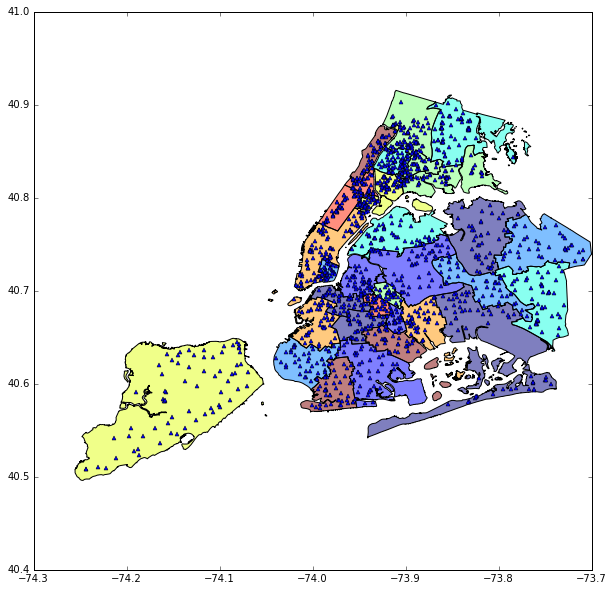

In [6]:
# f, ax = plt.subplots(figsize=(12,10))
ax = nysd.plot(figsize=(12,10))
#f = ax.get_figure()
#ax1 = f.add_axes(schools.plot())
ax.plot(schools.lon, schools.lat, '^', markersize=4)
# ax.plot(schools.lon[schools.GEO_DISTRI==0], schools.lat[schools.GEO_DISTRI==0], '^r', markersize=8)

### Prepare data
+ need to get to single value for "demand" at both district and school level

In [7]:
# first check for duplicates of base data
nysd[nysd.SchoolDist.duplicated()]

,SchoolDist,Shape_Area,Shape_Leng,geometry
32,10,3282963.20003,7883.372435,(POLYGON ((-73.90893235175379 40.8721573480034...


In [8]:
# check duplicates and decide which to delete
nysd[nysd.SchoolDist==10]

,SchoolDist,Shape_Area,Shape_Leng,geometry
22,10,2.825398e+08,94971.138984,POLYGON ((-73.86789043713642 40.90298695418564...
32,10,3.282963e+06,7883.372435,(POLYGON ((-73.90893235175379 40.8721573480034...


In [9]:
# drop little piece of district - could also join it but this is easier and shouldn't matter
nysd = gpd.GeoDataFrame(nysd[~(nysd.index==32)])
# nysd.info()

In [ ]:
#schools.groupby('GEO_DISTRI')['Total Enrollment'].agg({'TotalEnrollment': np.sum, 'SchoolCount': 'count'})

In [10]:
# join summarized school metrics to districts (prototype just using total enrollment)
nysd = pd.merge(nysd, schools.groupby('GEO_DISTRI')['Total Enrollment'].agg({'TotalEnrollment': np.sum, 
                                                                             'SchoolCount': 'count'}), 
                left_on='SchoolDist', right_index=True)

In [11]:
# add inverse of graduation rate to School Districts
sd_grad['NoGradRate'] = 1 - sd_grad.percent_of_grads
#sd_grad.reset_index(inplace=True)
sd_grad.head(2)

,Unnamed: 0,GEO_DISTRI,cohort_year,total_students,#_total_grads,percent_of_grads,NoGradRate
0,0,1,2011,1081,648,0.599445,0.400555
1,1,2,2011,8539,6170,0.722567,0.277433


In [12]:
nysd = pd.merge(nysd, sd_grad.loc[:,('NoGradRate', 'GEO_DISTRI')], left_on='SchoolDist', right_on='GEO_DISTRI')
nysd.drop('GEO_DISTRI', inplace=True, axis=1)
nysd.head()

,SchoolDist,Shape_Area,Shape_Leng,geometry,TotalEnrollment,SchoolCount,NoGradRate
0,13,1.048871e+08,86613.431251,POLYGON ((-73.97906084845808 40.70594602847152...,24486,48,0.210472
1,22,3.855582e+08,271705.210827,(POLYGON ((-73.91990064336095 40.5996005216209...,33847,39,0.182066
2,1,3.516415e+07,28625.358551,"POLYGON ((-73.97177410965313 40.7258212813704,...",13021,35,0.400555
3,9,8.344409e+07,46648.227687,POLYGON ((-73.92129719686139 40.85428933988983...,35651,71,0.346900
4,32,5.203075e+07,37200.403801,POLYGON ((-73.91180710069432 40.70343495205995...,12954,27,0.440439


In [13]:
# inverse relative median income
socioecon['RelMedInc'] = 1 - (socioecon['Median income (dollars)'] / socioecon['Median income (dollars)'].max())
# percent of district's families without employment in last 12 months
socioecon['PctNoWorkers'] = socioecon['No workers in the past 12 months (%)'] / 100
# percent with high school or less
socioecon['PctHSorLess'] = 1 - (socioecon['Percent bachelor\'s degree or higher'] / 100)
#socioecon.head()

In [14]:
# add socioeconomic data to school district
nysd = pd.merge(nysd, socioecon.loc[:,('RelMedInc', 'PctNoWorkers', 'PctHSorLess')], 
                left_on='SchoolDist', right_index=True)
#nysd.head()

In [15]:
# Relative enrollment
nysd['RelEnroll'] = nysd.TotalEnrollment / nysd.TotalEnrollment.max()
#nysd.head(3)

In [16]:
print 'confirm unique code for schools', len(schools), len(schools.LOC_CODE.unique())
print 'and for districts', len(nysd), len(nysd.SchoolDist.unique())

confirm unique code for schools 1598 1598
and for districts 32 32


### District level allocation
1. top down model - within district only

In [17]:
# componenet multipliers - how heavily should each metric be weighted on a 0 - 1 scale?
# DOE / school data
studentM = 1 # weight for relative number of students
gradM = 1 # weight for inverse graduation rate of high schools in district
# socioeconomic multipliers
incomeM = 0.5 # weight for relative median income
employM = 0.5 # weight for percent of district's families that did not have a job in the last 12 months
educatM = 0.5 # weight for percent of district with a High School degree or less education

# calculate single specialist demand metric from component parts
nysd['Demand'] = nysd.loc[:,'RelEnroll']*studentM + nysd.loc[:,'NoGradRate']*gradM + \
nysd.loc[:,'RelMedInc']*incomeM + nysd.loc[:,'PctNoWorkers']*employM + nysd.loc[:,'PctHSorLess']*educatM

In [ ]:
nysd.head(1)

In [18]:
# specialist list for analysis - key set up to handle any number of specialists up to 1,000
### How many specialists are we assigning?
NumSpecialists = 100 
sKeys = ['s' + ('00'+str(i))[-3:] for i in range(NumSpecialists)]

In [19]:
### make minimum constraint based on ensuring every school has ~1 day per month with a specialist
MaxSchoolsPerMonth = 30
#print nysd.SchoolCount.sum() / float(len(sKeys))
#print sum(np.ceil(nysd.SchoolCount / MaxSchoolsPerMonth))

In [20]:
# assign specialists to districts 
# initial step: iterate through list of specialists assigning each to a school district
# @Params: 
### specList = list, agents' (specialists') unique identifiers, will be key of returned dictionary
### District = pandas.DataFrame, district within which to assign specialists
### Did = district ID column
### demandColumn = column name of value to split amongst agents in District DataFrame
### locCount = number of physical locations (for us: schools)
### maxLocs = maximum number of locations an agent can visit per month (eg 0.5 day per school, ~20 days in a month)
# @return - agentDict = {agentID: DistrictCode}
# @return - distDict = {DistrictID: {agents: [AgentID]}}
def assignToDistrict(agentList, District, Did, demandColumn, locCount, maxLocs):
    # temporary DataFrame for function
    tmp = pd.DataFrame(District.loc[:,(Did, demandColumn, locCount)])
    # get 'optimal' (average) demand per agent
    targetDemand = tmp[demandColumn].sum() / len(agentList)
    
    # 'minAgent' tells how many agents need to be assigned so district does not 
    ## have more locations than agents can visit
    tmp['minAgent'] = np.ceil(tmp[locCount] / maxLocs)
    
    # once minumum number of agents assigned, demandR is remaining demand
    tmp['demandR'] = tmp[demandColumn] - (tmp.minAgent * targetDemand)
    # tmp.sort_values(by='demandR', ascending=False, inplace=True) # unnecessary
    
    # district dictionary for output
    distDict = dict(zip(tmp[Did], tmp[Did]))
    for i in distDict.keys():
        distDict[i] = {} # reset each district to be an object
        distDict[i]['agents'] = [] # create array to hold agent IDs
    
    # agent dictionary to for output assignments
    agentDict = {}
    # iterate through agent IDs assigning to districts based on minumum agent number, then demand remaining
    Didx = 0 # row index to track which is *this* District
    aN = 0 # number of assigned agents for *this* district
    for a in agentList:
        #print 'agent ', a
        if aN < tmp.loc[Didx:Didx, :]['minAgent'].values[0]:
            agentDict[a] = {'district': ''}
            agentDict[a]['district'] = tmp.loc[Didx:Didx, :][Did].values[0]
            distDict[agentDict[a]['district']]['agents'].append(a) # add agent ID to agents serving this district
            aN += 1
#            print '1. assigned to {0} | aN={1} | minAgent={2} | Didx={3} |demandR={4}'.format(\
#agentDict[a], aN, tmp.loc[Didx:Didx, :]['minAgent'].values, Didx, tmp.loc[Didx:Didx, :]['demandR'].values)
        # have filled minimum quota of agents for *this* district
        else:
            # is there another district?
            if Didx < tmp.index.max():
                Didx += 1 # go to the next district
                aN = 0 # reset agent counter for new district
                agentDict[a] = {'district': ''}
                agentDict[a]['district'] = tmp.loc[Didx:Didx, :][Did].values[0]
                distDict[agentDict[a]['district']]['agents'].append(a) # add agent ID to agents serving this district
                aN += 1
#                print '2. assigned to {0} | aN={1} | minAgent={2} | Didx={3} |demandR={4}'.format(\
#agentDict[a], aN, tmp.loc[Didx:Didx, :]['minAgent'].values, Didx, tmp.loc[Didx:Didx, :]['demandR'].values)
            # made it through minimum number for all districts, now assign agents based on remaining demand
            else: 
                agentDict[a] = {'district': ''}
                agentDict[a]['district'] = tmp.loc[tmp['demandR'].idxmax():tmp['demandR'].idxmax(), :][Did].values[0]
                distDict[agentDict[a]['district']]['agents'].append(a) # add agent ID to agents serving this district
                # and decrement assigned district's remaining demand
                tmp.loc[tmp['demandR'].idxmax():tmp['demandR'].idxmax(), 'demandR'] -= targetDemand
                #print '3. assigned to {0} | aN={1} | minAgent={2} | Didx={3} |demandR={4}'.format(\
#agentDict[a], aN, tmp.loc[Didx:Didx, :]['minAgent'].values, Didx, tmp.loc[Didx:Didx, :]['demandR'].values)
    # return dictionary of assigned agents
    return (agentDict, distDict)

In [21]:
specialistAssignments, districtAssign = assignToDistrict(sKeys, nysd, 'SchoolDist', 
                                                         'Demand', 'SchoolCount', MaxSchoolsPerMonth)

In [22]:
specialistAssignments['s049']

{'district': 4}

In [23]:
# check how deterministic assignment performed - decent
avgDemand = []
avgSchools = []
for k in districtAssign.keys():
    aNum = len(districtAssign[k]['agents'])
    avgDemand.append(nysd[nysd.SchoolDist==k].Demand.values[0]/aNum)
    avgSchools.append(nysd[nysd.SchoolDist==k].SchoolCount.values[0]/aNum)
    print 'District {0} has {1} specialists, avg demand = {2:,.2f}'\
    .format(k, aNum, nysd[nysd.SchoolDist==k]['Demand'].values[0]/aNum)
    
avgDemand = np.array(avgDemand)
avgSchools = np.array(avgSchools)

District 1 has 2 specialists, avg demand = 0.55
District 2 has 4 specialists, avg demand = 0.35
District 3 has 2 specialists, avg demand = 0.47
District 4 has 2 specialists, avg demand = 0.61
District 5 has 3 specialists, avg demand = 0.47
District 6 has 3 specialists, avg demand = 0.49
District 7 has 4 specialists, avg demand = 0.44
District 8 has 4 specialists, avg demand = 0.45
District 9 has 4 specialists, avg demand = 0.46
District 10 has 4 specialists, avg demand = 0.51
District 11 has 3 specialists, avg demand = 0.56
District 12 has 4 specialists, avg demand = 0.44
District 13 has 2 specialists, avg demand = 0.52
District 14 has 2 specialists, avg demand = 0.61
District 15 has 3 specialists, avg demand = 0.43
District 16 has 3 specialists, avg demand = 0.47
District 17 has 3 specialists, avg demand = 0.47
District 18 has 3 specialists, avg demand = 0.45
District 19 has 3 specialists, avg demand = 0.56
District 20 has 4 specialists, avg demand = 0.44
District 21 has 3 specialists

Demand: mean= 0.49 | std= 0.06
Schools per specialist: mean= 16.00 | std= 4.55 | min= 9.0 | max= 28.0


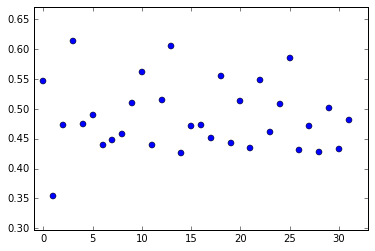

In [24]:
# check workload distribution numerically and graphically
print 'Demand: mean= {0:.2f} | std= {1:.2f}'.format(avgDemand.mean(), avgDemand.std())
print 'Schools per specialist: mean= {0:.2f} | std= {1:.2f} | min= {2:.1f} | max= {3:.1f}'\
.format(avgSchools.mean(), avgSchools.std(), avgSchools.min(), avgSchools.max())
plt.plot(np.array(range(len(avgDemand))), avgDemand, 'ob')
plt.ylim(avgDemand.min()-avgDemand.std(), avgDemand.max()+avgDemand.std())
plt.xlim(-1, len(avgDemand)+1)
plt.show()

In [25]:
# distance function to workaround geopandas.distance (dis)functionality
# courtesy: https://gist.github.com/rochacbruno/2883505
# future version could use travel time here instead of distance... ambitous.
def geoDist(lat1, lon1, lat2, lon2):
    #print 'lat1 %s | lon1 %s | lat2 %s | lon2 %s' % (lat1, lon1, lat2, lon2)
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

### Within District assignments
+ allocate specialists to individual schools

In [26]:
schools.loc[:,('LOC_CODE', 'lat','lon', 'geometry', 'Total Enrollment')].head(1)

,LOC_CODE,lat,lon,geometry,Total Enrollment
0,K001,40.649154,-74.011766,POINT (-74.01176589685977 40.64915359571094),1280


In [84]:
# test out steps for single school district
# 1) cluster District's schools by location
dTest = 31
dAgents = districtAssign[dTest]['agents']
km = KMeans(len(dAgents))
tmp = gpd.GeoDataFrame(schools[schools.GEO_DISTRI==dTest].loc[:,('LOC_CODE', 'lat','lon', 'geometry', 
                                                             'Total Enrollment')])
## for unconstrained version
#km = KMeans(100)
#tmp = gpd.GeoDataFrame(schools.loc[:,('LOC_CODE', 'lat','lon', 'geometry', 'Total Enrollment')])

tmp['group'] = km.fit_predict(tmp.loc[:,('lat', 'lon')])

In [85]:
# 2) check workload characteristics -> next goal is to minimize difference in workload ('students')
tmp.groupby('group')['Total Enrollment'].agg({'TotalEnrollment': 'sum', 'NumSchools': 'count'})

,TotalEnrollment,NumSchools
group,,
0,15809,23
1,16160,19
2,12783,12
3,15440,15


In [86]:
# 3) calculate distance to group center point
# 3a) center points
gCenters = tmp.groupby(['group'])['lat', 'lon'].mean()
#gCenters['geometry'] = gCenters.apply(lambda x: geom.Point(x.lon, x.lat), axis=1)
#gCenters = gpd.GeoDataFrame(gCenters)
#gCenters

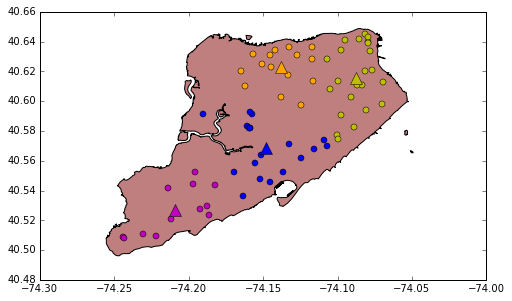

In [87]:
# probably set this aside in a different plotting function
ax = gpd.GeoDataFrame(nysd[nysd.SchoolDist==dTest]).plot(figsize=(8,8))
#ax = gpd.GeoDataFrame(nysd).plot(figsize=(16,10))
cols = ['m', 'y', 'b', 'orange']
for i, g in enumerate(tmp.group.unique()):
    ax.plot(tmp[tmp.group==g].lon, tmp[tmp.group==g].lat, 'o', c=cols[i])#, c=tmp.group)
    ax.plot(gCenters[gCenters.index==g].lon, gCenters[gCenters.index==g].lat, '^', markersize=12, c=cols[i])

In [88]:
# 3b) calculate school's distance to assigned center point
#gCenters.apply(lambda x: x.centroid.distance(tmp.geometry), axis=1)
#tmp.geometry.apply(lambda x: x.distance(gCenters.loc[0:0,:]))
tmp['gDist'] = tmp.apply(lambda x: geoDist(x.lat, x.lon,
                          gCenters.loc[x.group:x.group,'lat'].values[0], 
                          gCenters.loc[x.group:x.group,'lon'].values[0]),
                     axis=1)

In [89]:
# summarize enrollment to gCenters
gCenters = pd.merge(gCenters, tmp.groupby('group')['Total Enrollment'].agg({'TotalEnrollment': 'sum', 
                                                                           'NumSchools': 'count'}),
                   left_index=True, right_index=True)
gCenters.sort_values('TotalEnrollment', ascending=False, inplace=True)

In [90]:
gCenters

,lat,lon,TotalEnrollment,NumSchools
group,,,,
1,40.568732,-74.147768,16160,19
0,40.615829,-74.087620,15809,23
3,40.622721,-74.138160,15440,15
2,40.526722,-74.208926,12783,12


In [35]:
# wrapper around sklearn's nearest neighbor functionality
# @return: dictionary of {kK, index} for first row of
def knn(X, XIDs, k):
    n = NN(n_neighbors=k+1) # add 1 to get k nearest neighbors not including self
    D, A = n.fit(X).kneighbors(X, return_distance=True)
    # grab the indexes of first row - probably a way to not calculate all the other combinations...
    # A[0,1:].nonzero()[1][1:] # version for kneighbors_graph() which returns a sparse matrix
    Aout = [XIDs[a] for a in A[0,1:]]
    kNN = {'ID': Aout, 'Dist': D[0,1:]}
    return kNN
    #print kNN
    #out = {}
    #keys = ['k'+str(i) for i in range(k)]
    #for
    #return pd.Series(dict(zip(keys, kNN)))
    #return dict(zip(keys, kNN))

In [ ]:
tX = np.concatenate((gCenters[gCenters.index==2].loc[:,('lat', 'lon')].values,
                     gCenters[gCenters.index!=2].loc[:,('lat', 'lon')].values))
IDs = np.concatenate((gCenters[gCenters.index==2].index.values,
                     gCenters[gCenters.index!=2].index.values))
kNN_res = knn(tX, IDs, 2)


In [ ]:
kNN_res

In [ ]:
# adjacency list of two DataFrame inputs
# assumes both have lat/lon columns
# also updates df1 to include calculated k-nearest neighbors with ID and distance
# @return DataFrame with same index and k NN columns
def getAdjacencyList(df1, df2, k = 5):
    
    # call with df's apply function - can't figure it out, looping through
    #X = df1.loc[:,('lat','lon')].values
    # add output columns
    keys = ['k'+str(i) for i in range(k)]
    for kN in keys:
        df1[kN] = 0
        df1[kN+'_dist'] = 0
    # iterate through rows 
    for i, r in df1.iterrows():
        tX = np.concatenate(([np.array([r.lat, r.lon])],df2[df2.index!=i].loc[:,('lat', 'lon')].values))
        XIDs = np.concatenate((np.array([i]),df2[df2.index!=i].index.values))
        kNN_res = knn(tX, XIDs, k)
        # update output's columns
        for j, kN in enumerate(keys):
            df1.loc[i,kN] = kNN_res['ID'][j]
            df1.loc[i,kN+'_dist'] = kNN_res['Dist'][j]
            
    # return df1's kNN columns:
    return df1.iloc[:,-len(keys)*2:]

In [42]:
#gCenters
#gCenters.TotalEnrollment.idxmax()
gCenters.loc[maxG:maxG, ('lat', 'lon')]

,lat,lon
group,,
1,40.568732,-74.147768


In [51]:
#tmp.head()
tmp.loc[gKNN, :]

LOC_CODE                                                    R042
lat                                                      40.5522
lon                                                     -74.1695
geometry            POINT (-74.16954343082712 40.55224303991967)
Total Enrollment                                             970
group                                                          1
gDist                                                    2.59723
Name: 987, dtype: object

In [74]:
#gCenters = pd.merge(gCenters, tmp.groupby('group')['Total Enrollment'].agg({'TotalEnrollment': 'sum', 
#                                                                           'NumSchools': 'count'}),
#                   left_index=True, right_index=True)
gCenters

,lat,lon,TotalEnrollment,NumSchools
group,,,,
0,40.568732,-74.147768,16160,19
2,40.615829,-74.087620,15809,23
1,40.622721,-74.138160,15440,15
3,40.526722,-74.208926,12783,12


In [73]:
gCenters.NumSchools.idxmax()

2

In [93]:
#### step 3b: ensure initial assignments less than maximum allowed, 
    # if not move schools to nearest other group
c = 0 # counter to stop while loop from just pushing schools back and forth
maxVal = gCenters.NumSchools.max()
while (maxVal > 20) & (c < 5):
    maxG = gCenters.NumSchools.idxmax()
    # nearest other group
    gX = np.concatenate((gCenters.loc[maxG:maxG, ('lat', 'lon')].values,
                          tmp[tmp.group!=maxG].loc[:,('lat', 'lon')].values))
    gIDs = np.concatenate((np.array([maxG]),tmp[tmp.group!=maxG].index.values))
    gKNN = knn(gX, gIDs, 1)['ID'][0]
    print 'pre', gKNN, tmp.loc[gKNN, 'group']
    newG = tmp.loc[gKNN, 'group']
    print 'iteration {0} | maxG: {1} | newG: {2}'.format(c, maxG, newG)
    # nearest school to that group's center
    gX = np.concatenate((gCenters.loc[newG:newG, ('lat', 'lon')].values,
                          tmp[tmp.group==maxG].loc[:,('lat', 'lon')].values))
    gIDs = np.concatenate((np.array([maxG]),tmp[tmp.group==maxG].index.values))
    gKNN = knn(gX, gIDs, 1)['ID'][0]
    tmp.loc[gKNN, 'group'] = newG
    print 'post', tmp.loc[gKNN, 'group']
    gCenters = tmp.groupby(['group'])['lat', 'lon'].mean()
    gCenters = pd.merge(gCenters, tmp.groupby('group')['Total Enrollment'].agg({'TotalEnrollment': 'sum', 
                                                                           'NumSchools': 'count'}),
                   left_index=True, right_index=True)
    maxVal = gCenters.NumSchools.max()
    c += 1

gCenters.sort_values('TotalEnrollment', ascending=False, inplace=True)
gCenters

pre 976 3
iteration 0 | maxG: 0 | newG: 3
post 3
pre 989 3
iteration 1 | maxG: 0 | newG: 3
post 3
pre 1007 3
iteration 2 | maxG: 0 | newG: 3
post 3


,lat,lon,TotalEnrollment,NumSchools
group,,,,
3,40.621734,-74.132480,18043,18
1,40.568732,-74.147768,16160,19
0,40.615683,-74.085151,13206,20
2,40.526722,-74.208926,12783,12


In [91]:
gCenters.sort_values('TotalEnrollment', ascending=False, inplace=True)

In [92]:
gCenters

,lat,lon,TotalEnrollment,NumSchools
group,,,,
1,40.568732,-74.147768,16160,19
0,40.615829,-74.087620,15809,23
3,40.622721,-74.138160,15440,15
2,40.526722,-74.208926,12783,12


In [ ]:
# 4) reassign schools to even out agent's workload
# this is where minimization will come in... somehow
# logic:
### a. begin with highest workload group -> 'candidates'
### b. identify schools farthest from group that 
######## (0) are in an 'adjacent' cluster - build in room for flexible adjacency criteria
######## (i) are closer to other group than *this* group's center point
######## (ii) when removed will not reduce my group's workload to below District's mean
### c. assign identified points to nearest *other* group(s)

#maxGroup = gCenters.TotalEnrollment.idxmax()
def reassignGroups(maxGroup, groupCol, distCol):
    # potential candidates are any location in this group, start with those farthest from group's centroid
    candidates = tmp[tmp[groupCol]==maxGroup].sort_values(distCol, ascending=False)
    candidates['Selected'] = 0 # column to pass through step (b) of logic
    #candidates['pDist'] = tmp.gDist.max() # column to hold distance to potential reassignment
    candidates['pGroup'] = maxGroup # column to update if passes through logic

    # b.ii break criteria
    groupCutoff = candidates['Total Enrollment'].sum() - gCenters.TotalEnrollment.mean()
    wlShift = 0 # keep track of how much workload we're transfering
    
    if groupCutoff < 0:
        return 'below average group: %s' % (maxGroup)

    # identify potential groups to which candidates can be reassigned
    if len(gCenters) < 3:
        adjGroups = gCenters[gCenters.index!=maxGroup].index.values
    else:
        adjGroups = adjList.loc[maxGroup,:].values
    others = tmp[tmp[groupCol].isin(adjGroups)]
    
    # TO DO: pull most of this out of the loop(s) and only iterate through the actual reassignment portion
    for i, r in candidates.iterrows():
        # step b.i of reassignment logic
        closer = {} # temporary dict to check distance criteria
        closer['group'] = maxGroup 
        #closer['distance'] = r.gDist
        for iC, rC in others.iterrows():
            # distance from *this candidate* to *this other* location
            d = geoDist(r.lat, r.lon, rC.lat, rC.lon)
            # distance from *this other* to candidate's group center
            groupD = geoDist(gCenters.loc[maxGroup, 'lat'], gCenters.loc[maxGroup, 'lon'], rC.lat, rC.lon)
            # distance from *this candidate's* group center to *this other's* group center
            groupDP = geoDist(gCenters.loc[maxGroup, 'lat'], gCenters.loc[maxGroup, 'lon'], 
                              gCenters.loc[rC[groupCol], 'lat'], gCenters.loc[rC[groupCol], 'lon'])
            # check if
            # a) candidate is closer to some point in potential new group and
            # b) candidate is closer to old center than potential new center is to old center
            if (d < groupD) & (r.gDist < groupDP):
                #closer['distance'] = d if d < groupD else closer['distance']
                closer['group'] = rC.group
        # through other groups' locations, reassign this candidate?
        if closer['group'] != r.group:
            candidates.loc[i, 'Selected'] = 1
            #candidates.loc[i, 'pDist'] = closer['distance']
            candidates.loc[i, 'pGroup'] = closer['group']
        #print 'i= {0} | closestGroup {1} | closestDist {2:.3f}'.format(i, closer['group'], closer['distance'])

        # step b.ii of reassignment logic
        if candidates.loc[i, 'Selected']==0:
            continue # this row was not selected in step b.i, skip
        else:
            # if record would drop group below cutoff value so reset 'Selected', then continue to next record
            if wlShift+r['Total Enrollment'] > groupCutoff:
                candidates.loc[i, 'Selected'] = 0
            else:
                wlShift += r['Total Enrollment'] # increment value to shift
                # if made here can reassign group
                tmp.loc[i, 'group'] = candidates.loc[i, 'pGroup']
    return 'tmp updated with reassigned schools for group %s' % (maxGroup)

In [ ]:
# adjacency - how many neighbors should we include in the analysis?
# default to all groups
adjNum = len(gCenters)

# only can do if have more than 2
if len(gCenters) > 2:
    adjList = getAdjacencyList(gCenters, gCenters, adjNum-1)

In [ ]:
# iterate through initial groups from KMeans and reassign schools to shift workload
# TO DO: add logic to assign to lower workload groups
for i, r in gCenters.iterrows():
    print reassignGroups(i, 'group', 'gDist')
    print 'i %s TE= %s | update= %s' % (i, r.TotalEnrollment, tmp[tmp.group==i]['Total Enrollment'].sum())

In [ ]:
print tmp.groupby('group')['Total Enrollment'].agg({'sum', 'mean', 'count'})

In [ ]:
# recalculate gCenters with new data
gCenters = tmp.groupby(['group'])['lat', 'lon'].mean()
gCenters = pd.merge(gCenters, tmp.groupby('group')['Total Enrollment'].agg({'TotalEnrollment': 'sum', 
                                                                           'NumSchools': 'count'}),
                   left_index=True, right_index=True)

# and recalculate distances from each school to it's new group centroid
tmp['gDist'] = tmp.apply(lambda x: geoDist(x.lat, x.lon,
                          gCenters.loc[x.group:x.group,'lat'].values[0], 
                          gCenters.loc[x.group:x.group,'lon'].values[0]),
                     axis=1)

#print gCenters.loc[:,('TotalEnrollment', 'NumSchools')].std()
#print
#print gCenters.loc[:,('TotalEnrollment', 'NumSchools')].max()
#print
#print gCenters.loc[:,('TotalEnrollment', 'NumSchools')].min()

In [ ]:
ax = gpd.GeoDataFrame(nysd[nysd.SchoolDist==dTest]).plot(figsize=(8,8))
cols = ['m', 'y', 'b', 'orange']
for i, g in enumerate(tmp.group.unique()):
    ax.plot(gCenters[gCenters.index==g].lon, gCenters[gCenters.index==g].lat, '^', markersize=12, c=cols[i])
    ax.plot(tmp[tmp.group==g].lon, tmp[tmp.group==g].lat, 'o', c=cols[i])#, c=tmp.group)

In [ ]:
# add agent key to grouped assignments
gCenters['agentID'] = ''
for i, r in gCenters.iterrows():
    gCenters.loc[i, 'agentID'] = dAgents[i]

In [ ]:
gCenters

### Territory reporting metrics
+ summary of school 'need' metric - here just total enrollment
+ summary of distances between specialists' school assignments


In [ ]:
specialistAssignments['s011']['SchoolSummary'] = tmp[tmp.group==1].\
groupby('group')['Total Enrollment'].\
agg({'AvgNeed': 'mean', 'MinNeed': 'min', 'MaxNeed': 'max','TotalNeed': 'sum', 'StDevNeed': 'std'})
specialistAssignments['s011']['SchoolSummary'].reset_index(inplace=True)
specialistAssignments['s011']['SchoolSummary']['group'] = 's011'
specialistAssignments['s011']['SchoolSummary'].set_index('group',inplace=True)

In [ ]:
specialistAssignments['s011']['SchoolSummary']

In [ ]:
specialistAssignments['s011']['DistanceSummary'] = tmp[tmp.group==1].\
groupby('group')['gDist'].\
agg({'AvgDistance': 'mean', 'MinDistance': 'min', 'MaxDistance': 'max',
     'TotalDistance': 'sum', 'StDevDistance': 'std'})
specialistAssignments['s011']['DistanceSummary'].reset_index(inplace=True)
specialistAssignments['s011']['DistanceSummary']['group'] = 's011'
specialistAssignments['s011']['DistanceSummary'].set_index('group',inplace=True)
specialistAssignments['s011']['DistanceSummary']